In [2]:
import numpy as np
import pandas as pd 


In [3]:
data = pd.read_excel("BRE.xlsx")

In [4]:
data

,type,VP-EL,VP-GO,VP-ES,tram,bus,2RM,marche,velo,train
0,Mpkm (ville),0,6113.798302,2497.185222,189.461793,439.420576,111.071030,295.775446,138.150793,182.556476
1,Mpkm (rural),0,11310.409492,4619.744722,21.732545,637.072014,185.243366,204.916676,164.017298,193.149817
2,Mvkm (ville),0,4132.195625,1687.798213,189.461793,439.420576,111.071030,295.775446,138.150793,182.556476
3,Mvkm (rural),0,7644.482581,3122.394294,21.732545,637.072014,185.243366,204.916676,164.017298,193.149817
4,CO2/vkm (ville),0.255,174.000000,184.000000,3.800000,136.000000,64.000000,0.000000,0.000000,7.500000
5,CO2/vkm (rural),0.255,195.000000,208.000000,3.800000,136.000000,64.000000,0.000000,0.000000,7.500000
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Moyenne de Tx remplissage local,en kWh/km,1.479552,1.479552,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,1.479552,1.479552,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Changement d'unité
list_transport = data.columns[1:]
list_transport = list_transport.tolist()
mpkm_ville = data.loc[data['type'] == 'Mpkm (ville)'].to_numpy()[:, 1:].squeeze() * 1e6 # km
mpkm_rural = data.loc[data['type'] == 'Mpkm (rural)'].to_numpy()[:, 1:].squeeze() * 1e6 # km

mvkm_ville = data.loc[data['type'] == 'Mvkm (ville)'].to_numpy()[:, 1:].squeeze() * 1e6 # km
mvkm_rural = data.loc[data['type'] == 'Mvkm (rural)'].to_numpy()[:, 1:].squeeze() * 1e6 # km

# Calcul de l'empreinte carbone de chaque mode de transport
CO2_ville = data.loc[data['type'] == 'CO2/vkm (ville)'].to_numpy()[:, 1:].squeeze() / 1e6 # tCO2/km
CO2_rural = data.loc[data['type'] == 'CO2/vkm (rural)'].to_numpy()[:, 1:].squeeze() / 1e6 # tCO2/km

CO2_ville[0] = CO2_ville[0] * 0.55 # kw/h -> tCO2/km
CO2_rural[0] = CO2_rural[0] * 0.55 # kw/h -> tCO2/km



In [6]:
mvkm_rural

array([0.0, 7644482580.927462, 3122394293.618259, 21732545.10066243,
       637072013.9030439, 185243365.7370841, 204916676.1478354,
       164017297.93469483, 193149816.52618092], dtype=object)

In [7]:
def get_emission_region(mvkm, CO2perkm, part_traffic_total = 0.2):
    """get_emission_region calculate the emission of the region given it's traffic part


    Parameters
    ----------
    mvkm : np.ndarray
        Millions of vehicule.km
    CO2perkm : 
        CO2 emitted per km for each vehicule, CO2/vehicule.km
    part_traffic_total : float, optional
        percentage of the emission bilan of the region that is due to traffic, by default 0.2

    Returns
    -------
    float
        CO2 emission in Mtons
    """
    return sum(mvkm * CO2perkm ) / 1e6 * 1/part_traffic_total

def convert_pkm_into_vkm(mpkm, passperveh):
    """convert_pkm_into_vkm convert passenger.km into vehicule.km


    Parameters
    ----------
    mpkm : 
        Millions of passenger.km
    passperveh : _type_
        passenger per vehicule

    Returns
    -------
    _type_
        millions of vehicule.km
    """

    return mpkm / passperveh

def car_share(mpkm, on=True, initial_occupation_VP=1.5, increase_in_percentage = 15):
    """car_share change the car share of the region


    Parameters
    ----------
    mpkm : np.ndarray
        Millions of passenger.km
    on : bool, optional
        True if the car share is increased, by default True
    initial_occupation_VP : float, optional
        initial occupation of the vehicule, by default 1.5
    increase_in_percentage : int, optional
        increase in percentage of the car share, by default 15

    Returns 
    -------
    np.ndarray
        Millions of passenger.km
    """
    
    occupation = np.ones_like(mpkm)
    if on:
        occupation[0:3] = initial_occupation_VP * (1 + increase_in_percentage/100)
        return convert_pkm_into_vkm(mpkm, occupation)
    else:
        occupation[0:3] = initial_occupation_VP
        return convert_pkm_into_vkm(mpkm, occupation)



def modal_change(mpkm, switch_matrix):
    """modal_change change the modal share of the region


    Parameters
    ----------
    mpkm : np.ndarray
        Millions of passenger.km
    switch_matrix : np.ndarray
        switch matrix

    Returns
    -------
    np.ndarray
        Millions of passenger.km
    """

    mpkm = mpkm.copy()
    for idx in range(len(mpkm)):
        mpkm[idx] = mpkm[idx] + sum(switch_matrix[:, idx] )  - sum(switch_matrix[idx, :])
    return mpkm

N = len(list_transport)
switch_matrix_modal = np.zeros((N,N))
switch_matrix_modal[1, 0] = 0.9
switch_matrix_modal[2, 0] = 0.9
def make_VP_to_VE_switch_matrix(mpkm, proportion_switched = 0.9):
    """make_VP_to_VE_switch_matrix create a switch matrix from VP to VE


    Parameters
    ----------
    mpkm : np.ndarray
        Millions of passenger.km
    proportion_switched : float, optional
        proportion of the traffic that is switched, by default 0.9

    Returns
    -------
    np.ndarray
        switch matrix
    """
    
    N = len(mpkm)
    switch_matrix_EV = np.zeros((N,N))
    switch_matrix_EV[1, 0] = proportion_switched * mpkm[1]
    switch_matrix_EV[2, 0] = proportion_switched * mpkm[2]
    return switch_matrix_EV


def make_VP_more_efficient(CO2, increase_in_percentage = 50):
    CO2 = CO2.copy()
    CO2[1:3] = CO2[1:3] * (1 - increase_in_percentage/100)
    return CO2

def make_fuel_more_efficient(CO2, increase_in_percentage = 50):
    CO2 = CO2.copy()
    CO2[1:3] = CO2[1:3] * (1 - increase_in_percentage/100)
    return CO2



# switch_matrix_EV = np.zeros((N,N))
# switch_matrix_EV[1, 0] = 0.9 * mpkm[1]
# switch_matrix_EV[2, 0] = 0.9 * mpkm[2]
# switch_matrix_EV = switch_matrix_EV 


switch_matrix_modal_ville = np.zeros((N,N))
switch_matrix_modal_ville[1:3,list_transport.index('tram')] = mpkm_ville[list_transport.index('tram')] * (50/100) * np.ones(2)/2
switch_matrix_modal_ville[1:3,list_transport.index('bus')] = mpkm_ville[list_transport.index('bus')] * (30/100) * np.ones(2)/2
switch_matrix_modal_ville[1:3,list_transport.index('train')] = mpkm_ville[list_transport.index('train')] * (50/100) * np.ones(2)/2

switch_matrix_modal_ville[1,list_transport.index('velo')] = (sum(mpkm_ville) - mpkm_ville[list_transport.index('velo')])* (15/100)  

switch_matrix_modal_rural = np.zeros((N,N))
# switch_matrix_modal_rural[1:3,list_transport.index('tram')] = mpkm_rural[list_transport.index('tram')] * (50/100) * np.ones(2)/2
# switch_matrix_modal_rural[1:3,list_transport.index('bus')] = mpkm_rural[list_transport.index('bus')] * (30/100) * np.ones(2)/2
switch_matrix_modal_rural[1:3,list_transport.index('train')] = mpkm_rural[list_transport.index('train')] * (50/100) * np.ones(2)/2

# switch_matrix_modal_rural[1,list_transport.index('velo')] = (sum(mpkm_rural) - mpkm_rural[list_transport.index('velo')])* (15/100)  

In [8]:
switch_matrix_EV = make_VP_to_VE_switch_matrix(mpkm_ville, proportion_switched = 0.9)
switch_matrix_EV 

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [5.50241847e+09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.24746670e+09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.0

In [9]:
sum(mpkm_rural+mpkm_ville)/1e6

27303.705566326487

In [10]:
sum(mvkm_ville + mvkm_rural)/1e6

19349.438542242886

In [37]:
# make a dataframe with the results of the simulation of the different scenarios

df = pd.DataFrame(columns=['scenario', 'emission', 'emission_region', 'reduction_emission'])



# emission de la région
mvkm_ville = car_share(mpkm_ville, on=False, initial_occupation_VP=1.5, increase_in_percentage = 15)
mvkm_rural = car_share(mpkm_rural, on=False, initial_occupation_VP=1.5, increase_in_percentage = 15)

emission_ville = get_emission_region(mvkm_ville, CO2_ville, part_traffic_total = 1)
print("Emission de la ville: ", emission_ville, "Mtons")
emission_rural = get_emission_region(mvkm_rural, CO2_rural, part_traffic_total = 1)
print("Emission rural: ", emission_rural, "Mtons")
emission_region = (emission_ville + emission_rural)
print("Emission de transport région: ", emission_region, "Mtons")
print("Emission de la région: ", emission_region/0.14, "Mtons")

# add the results to the dataframe as new line 
df.loc[0] = ['emissions initiales', emission_region, emission_region/0.14, 0]


# emission de la région avec 10% de moins de traffic
mvkm_ville_10 = car_share(mpkm_ville * .9, on=False, initial_occupation_VP=1.5, increase_in_percentage = 15)
mvkm_rural_10 = car_share(mpkm_rural * .9, on=False, initial_occupation_VP=1.5, increase_in_percentage = 15)
print('---------------')
print('10% de moins de traffic')
print('---------------')
emission_ville_10 = get_emission_region(mvkm_ville_10, CO2_ville, part_traffic_total = 1)
print("Emission de la ville: ", emission_ville_10, "Mtons")
emission_rural_10 = get_emission_region(mvkm_rural_10, CO2_rural, part_traffic_total = 1)
print("Emission rural: ", emission_rural_10, "Mtons")
emission_region_10 = (emission_ville_10 + emission_rural_10)
print("Emission de transport région: ", emission_region_10, "Mtons")
print("Emission de la région: ", emission_region_10/0.14, "Mtons")

print("Reduction de l'empreinte carbone: ", (emission_region - emission_region_10)/emission_region * 100, "%")

# add the results to the dataframe as new line
df.loc[1] = ['10% de moins de traffic', emission_region_10, emission_region_10/0.14, (emission_region - emission_region_10)/emission_region * 100]


# emission de la région avec 10% de moins de traffic et partage de voiture
mvkm_ville_10 = car_share(mpkm_ville * .9, on=True, initial_occupation_VP=1.5, increase_in_percentage = 15)
mvkm_rural_10 = car_share(mpkm_rural * .9, on=True, initial_occupation_VP=1.5, increase_in_percentage = 15)
print('---------------')
print('10% de moins de traffic et partage de voiture')
print('---------------')
emission_ville_10 = get_emission_region(mvkm_ville_10, CO2_ville, part_traffic_total = 1)
print("Emission de la ville: ", emission_ville_10, "Mtons")
emission_rural_10 = get_emission_region(mvkm_rural_10, CO2_rural, part_traffic_total = 1)
print("Emission rural: ", emission_rural_10, "Mtons")
emission_region_10 = (emission_ville_10 + emission_rural_10)
print("Emission de transport région: ", emission_region_10, "Mtons")
print("Emission de la région: ", emission_region_10/0.14, "Mtons")

print("Reduction de l'empreinte carbone: ", (emission_region - emission_region_10)/emission_region * 100, "%")

# add the results to the dataframe as new line
df.loc[2] = ['partage de voiture', emission_region_10, emission_region_10/0.14, (emission_region - emission_region_10)/emission_region * 100]

# 10% de moins de traffic, partage de voiture et report modal
mvkm_ville_modal = car_share(modal_change(mpkm_ville * .9, switch_matrix_modal_ville) , on=True, initial_occupation_VP=1.5, increase_in_percentage = 15) 
mvkm_rural_modal = car_share(modal_change(mpkm_rural * .9, switch_matrix_modal_rural) , on=True, initial_occupation_VP=1.5, increase_in_percentage = 15) 
print('---------------')   
print('10% de moins de traffic, partage de voiture et report modal')
print('---------------')
emission_ville_modal = get_emission_region(mvkm_ville_modal, CO2_ville, part_traffic_total = 1)
print("Emission de la ville: ", emission_ville_modal, "Mtons")
emission_rural_modal = get_emission_region(mvkm_rural_modal, CO2_rural, part_traffic_total = 1)
print("Emission rural: ", emission_rural_modal, "Mtons")
emission_region_modal = (emission_ville_modal + emission_rural_modal)
print("Emission de transport région: ", emission_region_modal, "Mtons")
print("Emission de la région: ", emission_region_modal/0.14, "Mtons")

print("Reduction de l'empreinte carbone: ", (emission_region - emission_region_modal)/emission_region * 100, "%")

# add the results to the dataframe as new line
df.loc[3] = ['report modal', emission_region_modal, emission_region_modal/0.14, (emission_region - emission_region_modal)/emission_region * 100]

# 10% de moins de traffic, partage de voiture, report modal et du report VP -> VE
mvkm_ville_modal = car_share(modal_change(mpkm_ville * .9, switch_matrix_modal_ville) , on=True, initial_occupation_VP=1.5, increase_in_percentage = 15) 
mvkm_rural_modal = car_share(modal_change(mpkm_rural * .9, switch_matrix_modal_rural) , on=True, initial_occupation_VP=1.5, increase_in_percentage = 15) 
switch_matrix_EV_ville = make_VP_to_VE_switch_matrix(mvkm_ville_modal, proportion_switched = 0.9)
switch_matrix_EV_rural = make_VP_to_VE_switch_matrix(mvkm_rural_modal, proportion_switched = 0.9)
mvkm_ville_EV = modal_change(mvkm_ville_modal, switch_matrix_EV_ville)
mvkm_rural_EV = modal_change(mvkm_rural_modal, switch_matrix_EV_rural)
print('---------------')
print('10% de moins de traffic, partage de voiture et report modal et du report VP -> VE')
print('---------------')
emission_ville_EV = get_emission_region(mvkm_ville_EV, CO2_ville, part_traffic_total = 1)
print("Emission de la ville: ", emission_ville_EV, "Mtons")
emission_rural_EV = get_emission_region(mvkm_rural_EV, CO2_rural, part_traffic_total = 1)
print("Emission rural: ", emission_rural_EV, "Mtons")
emission_region_EV = (emission_ville_EV + emission_rural_EV)
print("Emission de transport région: ", emission_region_EV, "Mtons")
print("Emission de la région: ", emission_region_EV/0.14, "Mtons")

print("Reduction de l'empreinte carbone: ", (emission_region - emission_region_EV)/emission_region * 100, "%")

# add the results to the dataframe as new line
df.loc[4] = ['report VP -> VE', emission_region_EV, emission_region_EV/0.14, (emission_region - emission_region_EV)/emission_region * 100]

# 10% de moins de traffic, partage de voiture, report modal et du report VP -> VE et amélioration des VP et des carburants
mvkm_ville_modal = car_share(modal_change(mpkm_ville * .9, switch_matrix_modal_ville) , on=True, initial_occupation_VP=1.5, increase_in_percentage = 15)
mvkm_rural_modal = car_share(modal_change(mpkm_rural * .9, switch_matrix_modal_rural) , on=True, initial_occupation_VP=1.5, increase_in_percentage = 15)
switch_matrix_EV_ville = make_VP_to_VE_switch_matrix(mvkm_ville_modal, proportion_switched = 0.9)
switch_matrix_EV_rural = make_VP_to_VE_switch_matrix(mvkm_rural_modal, proportion_switched = 0.9)
mvkm_ville_EV = modal_change(mvkm_ville_modal, switch_matrix_EV_ville)
mvkm_rural_EV = modal_change(mvkm_rural_modal, switch_matrix_EV_rural)
CO2_ville_EV = make_VP_more_efficient(CO2_ville, increase_in_percentage = 50)
CO2_rural_EV = make_VP_more_efficient(CO2_rural, increase_in_percentage = 50)
CO2_ville_EV = make_fuel_more_efficient(CO2_ville_EV, increase_in_percentage = 50)
CO2_rural_EV = make_fuel_more_efficient(CO2_rural_EV, increase_in_percentage = 50)
print('---------------')
print('10% de moins de traffic, partage de voiture et report modal et du report VP -> VE et amélioration des VP et des carburants')
print('---------------')
emission_ville_EV = get_emission_region(mvkm_ville_EV, CO2_ville_EV, part_traffic_total = 1)
print("Emission de la ville: ", emission_ville_EV, "Mtons")
emission_rural_EV = get_emission_region(mvkm_rural_EV, CO2_rural_EV, part_traffic_total = 1)
print("Emission rural: ", emission_rural_EV, "Mtons")
emission_region_EV = (emission_ville_EV + emission_rural_EV)
print("Emission de transport région: ", emission_region_EV, "Mtons")
print("Emission de la région: ", emission_region_EV/0.14, "Mtons")

print("Reduction de l'empreinte carbone: ", (emission_region - emission_region_EV)/emission_region * 100, "%")

# add the results to the dataframe as new line
df.loc[5] = ['amélioration  VP/carburants', emission_region_EV, emission_region_EV/0.14, (emission_region - emission_region_EV)/emission_region * 100]

Emission de la ville:  1.084480862860513 Mtons
Emission rural:  2.2109864119366383 Mtons
Emission de transport région:  3.295467274797151 Mtons
Emission de la région:  23.53905196283679 Mtons
---------------
10% de moins de traffic
---------------
Emission de la ville:  0.9760327765744615 Mtons
Emission rural:  1.9898877707429747 Mtons
Emission de transport région:  2.9659205473174364 Mtons
Emission de la région:  21.185146766553114 Mtons
Reduction de l'empreinte carbone:  9.999999999999991 %
---------------
10% de moins de traffic et partage de voiture
---------------
Emission de la ville:  0.8568193255513207 Mtons
Emission rural:  1.7420796770287588 Mtons
Emission de transport région:  2.5988990025800796 Mtons
Emission de la région:  18.563564304143423 Mtons
Reduction de l'empreinte carbone:  21.13716247599358 %
---------------
10% de moins de traffic, partage de voiture et report modal
---------------
Emission de la ville:  0.6940899670049158 Mtons
Emission rural:  1.731522919846521

In [38]:
df['reduction_emission'] = 100 - df['reduction_emission'].astype(float)

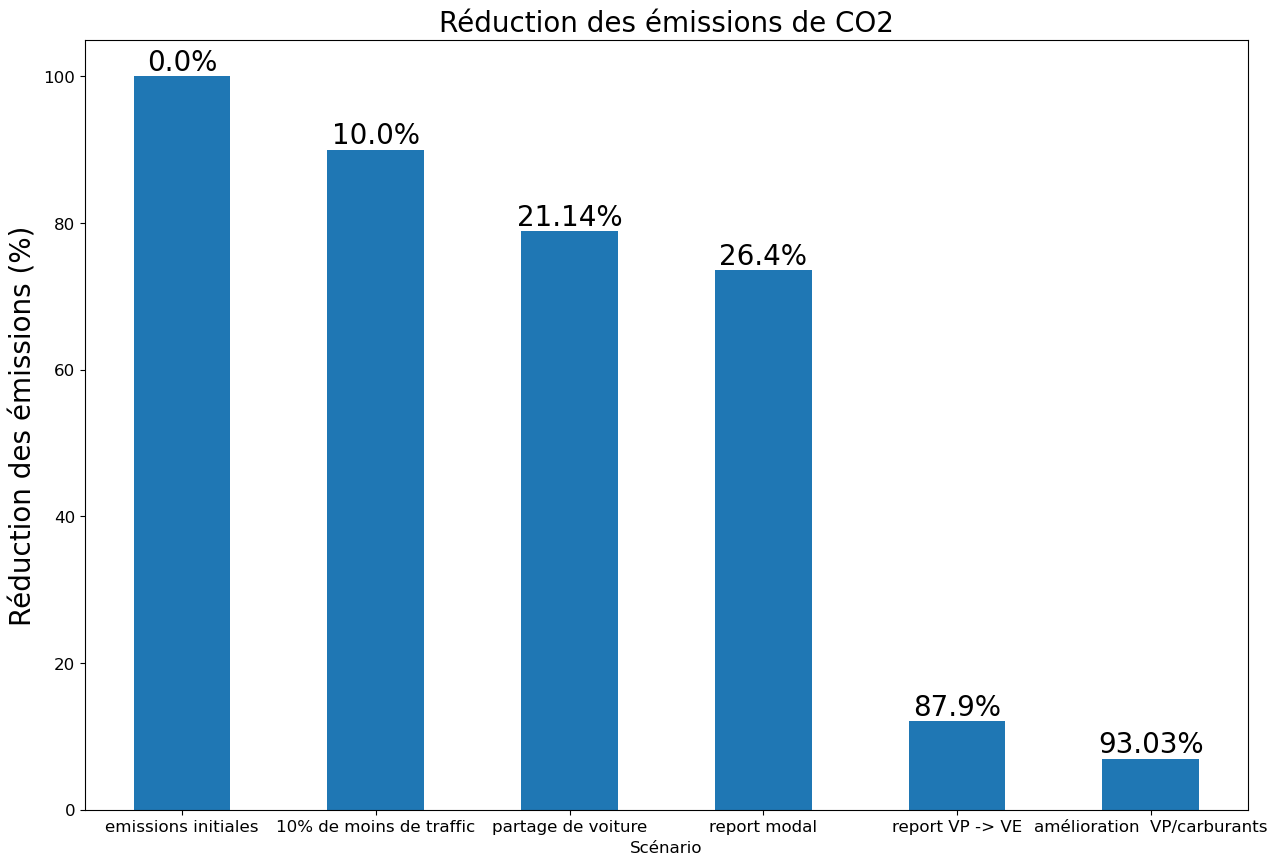

In [39]:
import  matplotlib.pyplot as plt
# plot the results with the value of the reduction of the emission in the bar
df.plot.bar(x='scenario', y='reduction_emission', rot=0, figsize=(15,10), fontsize=12, legend=False)

# add the value of the reduction of the emission on the top of the bar
for index, value in enumerate(df['reduction_emission'].values):
    plt.text(index, value, str(round(100-value,2)) + '%', fontsize=20, horizontalalignment='center', verticalalignment='bottom')
plt.xlabel('Scénario', fontsize=12)
plt.ylabel('Réduction des émissions (%)', fontsize=20)
plt.title('Réduction des émissions de CO2', fontsize=20)
plt.show()


In [40]:
# 10% de moins de traffic, partage de voiture, report modal et du report VP -> VE
mvkm_ville_modal = car_share(modal_change(mpkm_ville * .9, switch_matrix_modal_ville) , on=True, initial_occupation_VP=1.5, increase_in_percentage = 15) 
mvkm_rural_modal = car_share(modal_change(mpkm_rural * .9, switch_matrix_modal_rural) , on=True, initial_occupation_VP=1.5, increase_in_percentage = 15) 
switch_matrix_EV_ville = make_VP_to_VE_switch_matrix(mvkm_ville_modal, proportion_switched = 0.9)
switch_matrix_EV_rural = make_VP_to_VE_switch_matrix(mvkm_rural_modal, proportion_switched = 0.9)
mvkm_ville_EV = modal_change(mvkm_ville_modal, switch_matrix_EV_ville)
mvkm_rural_EV = modal_change(mvkm_rural_modal, switch_matrix_EV_rural)
print('---------------')
print('10% de moins de traffic, partage de voiture et report modal et du report VP -> VE')
print('---------------')
emission_ville_EV = get_emission_region(mvkm_ville_EV, CO2_ville, part_traffic_total = 1)
print("Emission de la ville: ", emission_ville_EV, "Mtons")
emission_rural_EV = get_emission_region(mvkm_rural_EV, CO2_rural, part_traffic_total = 1)
print("Emission rural: ", emission_rural_EV, "Mtons")
emission_region_EV = (emission_ville_EV + emission_rural_EV)
print("Emission de transport région: ", emission_region_EV, "Mtons")
print("Emission de la région: ", emission_region_EV/0.17, "Mtons")

print("Reduction de l'empreinte carbone: ", (emission_region - emission_region_EV)/emission_region * 100, "%")

# emission de la région avec du report modal et du report VP -> VE, 10% de moins de traffic, 15% de partage de voiture

---------------
10% de moins de traffic, partage de voiture et report modal et du report VP -> VE
---------------
Emission de la ville:  0.1427772601424978 Mtons
Emission rural:  0.25586935743934286 Mtons
Emission de transport région:  0.39864661758184067 Mtons
Emission de la région:  2.344980103422592 Mtons
Reduction de l'empreinte carbone:  87.90318384799076 %


In [13]:
(mvkm_ville_EV + mvkm_rural_EV ) / sum(mvkm_ville_EV + mvkm_rural_EV)

array([0.6347851758824338, 0.049001834842602926, 0.02152985136655635,
       0.023839430421108775, 0.0836684348877771, 0.021861088602598947,
       0.02656339354403768, 0.10361303847463782, 0.035137751978246375],
      dtype=object)

In [14]:
emission_total = get_emission_region(mvkm_ville + mvkm_rural, CO2_rural, part_traffic_total = 0.17)
print("Emission de la région: ", emission_total, "Mtons")

Emission de la région:  15.44746176091635 Mtons


In [15]:
mpkm_ville/sum(mpkm_ville)

array([0.0, 0.6021924428007632, 0.2459659273411568, 0.02738445737993177,
       0.04881295259224078, 0.019142159772074924, 0.026102766043342978,
       0.015268898686731988, 0.015130395383757527], dtype=object)

In [16]:
modal_change(mpkm_ville, switch_matrix_modal_ville)/sum(mpkm_ville)

array([0.0, 0.43653212152401466, 0.22801527126139834, 0.04107668606989765,
       0.063456838369913, 0.019142159772074924, 0.026102766043342978,
       0.16297856388372217, 0.02269559307563629], dtype=object)

In [17]:
list_transport.index('velo')

7

In [18]:
mpkm/sum(mpkm)

NameError: name 'mpkm' is not defined

In [ ]:


# fonction leviers
def sobriety(mpkm, reduction = 0.0):
    return mpkm * (1-reduction)

def co2_after_levers(mpkm, 
                     modal_change,
                     change_elec,
                     )

def levier_decarboner_thermique(mpkm, coef):
    mpkm_= mpkm.copy()
    mpkm_[1] = mpkm[1] * (1 - coef)
    mpkm_[2] = mpkm[2] * (1 - coef)
    return mpkm_

def levier_VP_thermique_plus_eff(mpkm, coef):
    mpkm_= mpkm.copy()
    mpkm_[1] = mpkm[1] * coef
    mpkm_[2] = mpkm[2] * coef
    return mpkm_


def activation_leviers(leviers, mpkm, CO2, part_traffic_total = 0.2):
    mpkm_ = mpkm.copy()
    for levier in leviers:
        if levier[0] == 'km':
            mpkm_ = levier_reduction_km(mpkm_, levier[1])
        elif levier[0] == 'remplissage_VP':
            mpkm_ = levier_augmenter_remplissage_VP(mpkm_, levier[1])
        elif levier[0] == 'changer_mode':
            mpkm_ = levier_changer_mode(mpkm_, levier[1], levier[2], levier[3], levier[4], levier[5], levier[6])
        elif levier[0] == 'changer_VP_thermique_en_VP_elec':
            mpkm_ = levier_changer_VP_thermique_en_VP_elec(mpkm_, levier[1])
        elif levier[0] == 'decarboner_thermique':
            mpkm_ = levier_decarboner_thermique(mpkm_, levier[1])
        elif levier[0] == 'VP_thermique_plus_eff':
            mpkm_ = levier_VP_thermique_plus_eff(mpkm_, levier[1])
    return mpkm_, get_emission_region(mpkm_, CO2, part_traffic_total)

In [ ]:
# tout les leviers activés : report modal VP vers TC, changement VP thermique vers VP électrique, levier efficacité VP thermique
leviers = [
            ['km', 0.1], 
            ['changer_VP_thermique_en_VP_elec', .9],
            ['remplissage_VP', 1.72], 
            ['changer_mode', tram, bus, deuxRM, marche, velo, train],
            ['VP_thermique_plus_eff', .5],
            ['decarboner_thermique', .3],
            ]
co2_levier_tout = activation_leviers(leviers, mpkm, CO2   )[1]
print('Reduction de CO2 en % après tous les leviers :', f'{(co2_sans_levier_reduction_km - co2_levier_tout)/co2_sans_levier_reduction_km * 100:2.2f} %')

Reduction de CO2 en % après tous les leviers : 90.88 %


In [ ]:
x = 500
y = 500

In [ ]:
print(x*.1)

50.0


In [ ]:
c=.2

In [ ]:
y/c*0.1 + y*( 1- 1/c)*0.1

50.0